### Imporing Libraries

In [3]:
# import torch
# import gc

# # 删除所有的张量变量
# for obj in gc.get_objects():
#     try:
#         if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#             del obj
#     except:
#         pass

# # 强制进行垃圾回收
# gc.collect()

# # 清理 PyTorch 的缓存
# torch.cuda.empty_cache()


In [4]:
!pip install ml_collections

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 864.8 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94507 sha256=6ed29df3befb5edfecfaa5bf28f5bbd8661058efa2acb4c943ddedec97e44877
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml_collections


In [1]:
import keras
import cv2
import keras.backend as K
from keras.datasets import cifar10, cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import albumentations as albu

from __future__ import absolute_import, division, print_function 
import ml_collections

2024-06-07 11:46:00.734409: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 11:46:00.780841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 11:46:01.567857: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os, copy, logging, math, random, time, typing, io
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import ndimage

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
import torchvision
from torchvision import transforms, datasets
import torch.distributed as dist
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler
from torch.optim.lr_scheduler import LambdaLR
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import utils
import torch.nn.functional as F
from torch.autograd import Variable

from matplotlib.colors import LogNorm 

from urllib.request import urlretrieve
from PIL import Image
from os.path import join as pjoin

from tqdm import tqdm
from datetime import timedelta



### Download Pre-trained model

In [7]:
!wget https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-06-04 11:10:53--  https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.207, 74.125.132.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412815506 (394M) [application/octet-stream]
Saving to: 'ViT-B_16.npz.1'

ViT-B_16.npz.1      100%[===================>] 393.69M  32.3MB/s    in 13s     

2024-06-04 11:11:07 (29.2 MB/s) - 'ViT-B_16.npz.1' saved [412815506/412815506]



### Check GPU Access

In [3]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  NVIDIA GeForce RTX 4090 D


### Configurations

In [4]:
def get_testing():
    '''
    Returns a minimal configuration for testing
    '''
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 1
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 1
    config.transformer.num_heads = 1
    config.transformer.num_layers = 1
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

def get_b16_config():
    '''
    Returns the ViT-B/16 configuration
    '''
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

def get_b32_config():
    '''
    Returns the ViT-B/32 configuration
    '''
    config = get_b16_config()
    config.patches.size = (32, 32)
    return config

def get_l16_config():
    '''
    Returns the ViT-L/16 configuration
    '''
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 1024
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 4096
    config.transformer.num_heads = 16
    config.transformer.num_layers = 24
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

def get_l32_config():
    '''
    Returns the ViT-L/32 configuration
    '''
    config = get_l16_config()
    config.patches.size = (32, 32)
    return config

def get_h14_config():
    '''
    Returns the ViT-L/16 configuration
    '''
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (14, 14)})
    config.hidden_size = 1280
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 5120
    config.transformer.num_heads = 16
    config.transformer.num_layers = 32
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

### Model Architecture

In [5]:
logger = logging.getLogger(__name__)

ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"


def np2th(weights):
    """Possibly convert HWIO to OIHW."""
    if weights.ndim == 4:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)

def swish(x):
    return x * torch.sigmoid(x)

ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}


class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class Embeddings(nn.Module):
    '''
    Construct the embeddings from patch, position embeddings
    '''
    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        img_size = _pair(img_size)
        patch_size = _pair(config.patches["size"])
        n_patches = (img_size[0]//patch_size[0]) * (img_size[1]//patch_size[1])

        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches+1, config.hidden_size))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        x = torch.cat((cls_tokens, x), dim=1)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            query_weight = np2th(weights[pjoin(ROOT, ATTENTION_Q, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel")]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias")]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias")]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias")]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias")]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel")]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel")]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias")]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias")]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale")]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias")]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale")]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias")]))


class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights


class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights


class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier

        self.transformer = Transformer(config, img_size, vis)
        self.head = Linear(config.hidden_size, num_classes)

    def forward(self, x, labels=None):
        x, attn_weights = self.transformer(x)
        logits = self.head(x[:, 0])

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_classes), labels.view(-1))
            return loss
        else:
            return logits, attn_weights

    def load_from(self, weights):
        with torch.no_grad():
            if self.zero_head:
                nn.init.zeros_(self.head.weight)
                nn.init.zeros_(self.head.bias)
            else:
                self.head.weight.copy_(np2th(weights["head/kernel"]).t())
                self.head.bias.copy_(np2th(weights["head/bias"]).t())

            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"]))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))
            self.transformer.embeddings.cls_token.copy_(np2th(weights["cls"]))
            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])
            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)

                if self.classifier == "token":
                    posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
                    ntok_new -= 1
                else:
                    posemb_tok, posemb_grid = posemb[:, :0], posemb[0]

                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)

                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = np.concatenate([posemb_tok, posemb_grid], axis=1)
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)


CONFIGS = {
    'ViT-B_16': get_b16_config(),
    'ViT-B_32': get_b32_config(),
    'ViT-L_16': get_l16_config(),
    'ViT-L_32': get_l32_config(),
    'ViT-H_14': get_h14_config(),
    'testing': get_testing(),
}

### Load Model

In [6]:
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, img_size=224, num_classes=21843, zero_head=False, vis=True)
model.load_from(np.load("ViT-B_16.npz"))
model.to(device)

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=Tru

### Utilities

In [7]:
def get_world_size():
    if not dist.is_available():
        return 1
    if not dist.is_initialized():
        return 1
    return dist.get_world_size()

### Dataloader

In [8]:
def get_loader(local_rank, img_size, dataset, train_batch_size, eval_batch_size):
    if local_rank not in [-1, 0]:
        torch.distributed.barrier()

    transform_train = transforms.Compose([
        transforms.RandomResizedCrop((img_size, img_size), scale=(0.05, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    if dataset == "cifar10":
        trainset = datasets.CIFAR10(root="./data",
                                    train=True,
                                    download=True,
                                    transform=transform_train)
        testset = datasets.CIFAR10(root="./data",
                                   train=False,
                                   download=True,
                                   transform=transform_test) if local_rank in [-1, 0] else None

    else:
        trainset = datasets.CIFAR100(root="./data",
                                     train=True,
                                     download=True,
                                     transform=transform_train)
        testset = datasets.CIFAR100(root="./data",
                                    train=False,
                                    download=True,
                                    transform=transform_test) if local_rank in [-1, 0] else None
    if local_rank == 0:
        torch.distributed.barrier()

    train_sampler = RandomSampler(trainset) if local_rank == -1 else DistributedSampler(trainset)
    test_sampler = SequentialSampler(testset)
    train_loader = DataLoader(trainset,
                              sampler=train_sampler,
                              batch_size=train_batch_size,
                              num_workers=4,
                              pin_memory=True)
    test_loader = DataLoader(testset,
                             sampler=test_sampler,
                             batch_size=eval_batch_size,
                             num_workers=4,
                             pin_memory=True) if testset is not None else None

    return train_loader, test_loader

### Scheduler

In [9]:
class ConstantLRSchedule(LambdaLR):
    """ Constant learning rate schedule.
    """
    def __init__(self, optimizer, last_epoch=-1):
        super(ConstantLRSchedule, self).__init__(optimizer, lambda _: 1.0, last_epoch=last_epoch)


class WarmupConstantSchedule(LambdaLR):
    """ Linear warmup and then constant.
        Linearly increases learning rate schedule from 0 to 1 over `warmup_steps` training steps.
        Keeps learning rate schedule equal to 1. after warmup_steps.
    """
    def __init__(self, optimizer, warmup_steps, last_epoch=-1):
        self.warmup_steps = warmup_steps
        super(WarmupConstantSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1.0, self.warmup_steps))
        return 1.


class WarmupLinearSchedule(LambdaLR):
    """ Linear warmup and then linear decay.
        Linearly increases learning rate from 0 to 1 over `warmup_steps` training steps.
        Linearly decreases learning rate from 1. to 0. over remaining `t_total - warmup_steps` steps.
    """
    def __init__(self, optimizer, warmup_steps, t_total, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        super(WarmupLinearSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1, self.warmup_steps))
        return max(0.0, float(self.t_total - step) / float(max(1.0, self.t_total - self.warmup_steps)))


class WarmupCosineSchedule(LambdaLR):
    """ Linear warmup and then cosine decay.
        Linearly increases learning rate from 0 to 1 over `warmup_steps` training steps.
        Decreases learning rate from 1. to 0. over remaining `t_total - warmup_steps` steps following a cosine curve.
        If `cycles` (default=0.5) is different from default, learning rate follows cosine function after warmup.
    """
    def __init__(self, optimizer, warmup_steps, t_total, cycles=.5, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        self.cycles = cycles
        super(WarmupCosineSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1.0, self.warmup_steps))
        # progress after warmup
        progress = float(step - self.warmup_steps) / float(max(1, self.t_total - self.warmup_steps))
        return max(0.0, 0.5 * (1. + math.cos(math.pi * float(self.cycles) * 2.0 * progress)))

### Training

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def simple_accuracy(preds, labels):
    return (preds == labels).mean()


def save_model(output_dir, name, model):
    model_to_save = model.module if hasattr(model, 'module') else model
    model_checkpoint = os.path.join(output_dir, "%s_checkpoint.bin" % name)
    torch.save(model_to_save.state_dict(), model_checkpoint)
    logger.info("Saved model checkpoint to [DIR: %s]", output_dir)


def setup(model_type, img_size, pretrained_dir, device, dataset):
    # Prepare model
    config = CONFIGS[model_type]

    num_classes = 10 if dataset == "cifar10" else 100

    model = VisionTransformer(config, img_size, zero_head=True, num_classes=num_classes)
    model.load_from(np.load(pretrained_dir))
    model.to(device)
    num_params = count_parameters(model)

    logger.info("{}".format(config))
    logger.info("Training parameters %s", model_type, img_size, pretrained_dir, device)
    logger.info("Total Parameter: \t%2.1fM" % num_params)
    return model_type, img_size, pretrained_dir, device, model


def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/1000000


def set_seed(seed, n_gpu):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(seed)

In [12]:
def valid(eval_batch_size, local_rank, device, model, writer, test_loader, global_step):
    # Validation!
    eval_losses = AverageMeter()

    logger.info("***** Running Validation *****")
    logger.info("  Num steps = %d", len(test_loader))
    logger.info("  Batch size = %d", eval_batch_size)

    model.eval()
    all_preds, all_label = [], []
    epoch_iterator = tqdm(test_loader,
                          desc="Validating... (loss=X.X)",
                          bar_format="{l_bar}{r_bar}",
                          dynamic_ncols=True,
                          disable=local_rank not in [-1, 0])
    loss_fct = torch.nn.CrossEntropyLoss()
    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to(device) for t in batch)
        x, y = batch
        with torch.no_grad():
            logits, attn_weights = model(x)

            eval_loss = loss_fct(logits, y)
            eval_losses.update(eval_loss.item())

            preds = torch.argmax(logits, dim=-1)

        if len(all_preds) == 0:
            all_preds.append(preds.detach().cpu().numpy())
            all_label.append(y.detach().cpu().numpy())
        else:
            all_preds[0] = np.append(
                all_preds[0], preds.detach().cpu().numpy(), axis=0
            )
            all_label[0] = np.append(
                all_label[0], y.detach().cpu().numpy(), axis=0
            )
        epoch_iterator.set_description("Validating... (loss=%2.5f)" % eval_losses.val)

    all_preds, all_label = all_preds[0], all_label[0]
    accuracy = simple_accuracy(all_preds, all_label)

    logger.info("\n")
    logger.info("Validation Results")
    logger.info("Global Steps: %d" % global_step)
    logger.info("Valid Loss: %2.5f" % eval_losses.avg)
    logger.info("Valid Accuracy: %2.5f" % accuracy)

    writer.add_scalar("test/accuracy", scalar_value=accuracy, global_step=global_step)
    writer.add_scalar("test/loss", scalar_value=eval_losses.avg, global_step=global_step)
    return accuracy, eval_losses.avg

In [14]:
import random
import numpy as np

def cutmix_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [15]:
def train(epoch_nums, local_rank, output_dir, name, train_batch_size, eval_batch_size, seed, n_gpu, gradient_accumulation_steps, dataset, img_size, learning_rate, weight_decay, num_steps, decay_type, warmup_steps, fp16, fp16_opt_level, device, max_grad_norm, eval_every, model):
    """ Train the model """
    if local_rank in [-1, 0]:
        os.makedirs(output_dir, exist_ok=True)
        writer = SummaryWriter(log_dir=os.path.join("logs", name))

    train_batch_size = train_batch_size // gradient_accumulation_steps

    # Prepare dataset
    train_loader, test_loader = get_loader(local_rank, img_size, dataset, train_batch_size, eval_batch_size)

    criterion = nn.CrossEntropyLoss()
    # Prepare optimizer and scheduler
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=0.9,
                                weight_decay=weight_decay)
    t_total = num_steps
    total_step = len(train_loader)
    if decay_type == "cosine":
        scheduler = WarmupCosineSchedule(optimizer, warmup_steps=warmup_steps, t_total=t_total)
    else:
        scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=t_total)

    # Distributed training
    if local_rank != -1:
        model = DDP(model, message_size=250000000, gradient_predivide_factor=get_world_size())

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Total optimization steps = %d", num_steps)
    logger.info("  Instantaneous batch size per GPU = %d", train_batch_size)
    logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                train_batch_size * gradient_accumulation_steps * (
                    torch.distributed.get_world_size() if local_rank != -1 else 1))
    logger.info("  Gradient Accumulation steps = %d", gradient_accumulation_steps)

    model.zero_grad()
    set_seed(seed, n_gpu)  # Added here for reproducibility (even between python 2 and 3)
    losses = AverageMeter()
    global_step, best_acc = 0, 0
    train_accs = []
    test_accs = []
    train_losses = []
    val_losses = []

    for epoch in range(epoch_nums):
        running_loss = 0
        running_corrects = 0
        model.train()
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
            
            r = np.random.rand(1)
            if r < 0.5:
            # generate mixed sample
                lam = np.random.beta(1, 1)
                rand_index = torch.randperm(inputs.size()[0]).to(device)
                target_a = labels
                target_b = labels[rand_index]
                bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
                inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
                # compute output
                inputs = inputs.float()
                optimizer.zero_grad()
                outputs = model(inputs)[0]
                loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b) * (1. - lam)
            else:
                # compute output
                inputs = inputs.float()
                optimizer.zero_grad()
                outputs = model(inputs)[0]
                loss = criterion(outputs, labels)

            loss.backward()
            losses.update(loss.item() * gradient_accumulation_steps)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scheduler.step()
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            
            if (batch_idx) % 200 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epoch_nums, batch_idx, total_step, losses.val))

            if local_rank in [-1, 0]:
                writer.add_scalar("train/loss", scalar_value=losses.val, global_step=global_step)
                writer.add_scalar("train/lr", scalar_value=scheduler.get_lr()[0], global_step=global_step)
#                 train_losses.append(losses.val)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects.double() / len(train_loader)
        
        train_accs.append(epoch_acc)
        train_losses.append(epoch_loss)

        if local_rank in [-1, 0]: # global_step % eval_every == 0 and 
            accuracy, val_loss = valid(eval_batch_size, local_rank, device, model, writer, test_loader, global_step)
            test_accs.append(accuracy)
            val_losses.append(val_loss)
            writer.add_scalar("val/loss", scalar_value=val_loss, global_step=global_step)
            writer.add_scalar("val/accuracy", scalar_value=accuracy, global_step=global_step)

            if best_acc < accuracy:
                save_model(output_dir, name, model)
                best_acc = accuracy
            model.train()
            
        losses.reset()

#     if local_rank in [-1, 0]:
#         writer.close()
    logger.info("Best Accuracy: \t%f" % best_acc)
    logger.info("End Training!")
    
    return train_accs, test_accs, train_losses, val_losses

In [16]:
def main():
    # Required parameters
    epoch_nums = 20
    name = "cifar10_500"                                # Name of this run. Used for monitoring
    dataset = "cifar100"                                 # Which downstream task, choices=["cifar10", "cifar100"]
    model_type = "ViT-B_16"                             # Which variant to use
    pretrained_dir = "ViT-B_16.npz"            # Where to search for pretrained ViT models
    output_dir = "output_cifar100"                       # The output directory where checkpoints will be written
    img_size = 224                                      # Resolution size
    train_batch_size = 32                               # Total batch size for training
    eval_batch_size = 32                                # Total batch size for eval
    eval_every = 100                                    # Run prediction on validation set every so many steps (Will always run one evaluation at the end of training)
    learning_rate = 3e-2                                # The initial learning rate for SGD
    weight_decay = 0                                    # Weight deay if we apply some
    num_steps = 500                                     # Total number of training epochs to perform
    decay_type = "cosine"                               # How to decay the learning rate, choices=["cosine", "linear"]
    warmup_steps = 100                                  # Step of training to perform learning rate warmup for
    max_grad_norm = 1.0                                 # Max gradient norm
    local_rank = -1                                     # local_rank for distributed training on gpus
    seed = 42                                           # random seed for initialization
    gradient_accumulation_steps = 1                     # Number of updates steps to accumulate before performing a backward/update pass
    fp16 = 0                                            # (action = 'store_true') Whether to use 16-bit float precision instead of 32-bit
    fp16_opt_level = 'store_true'                       # For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']
    loss_scale = 0                                      # Loss scaling to improve fp16 numeric stability. Only used when fp16 set to True (0 (default value): dynamic loss scaling, Positive power of 2: static loss scaling value)
    local_rank = -1                                     # local_rank for distributed training on gpus

    device="cpu"
    n_gpu = 0

    # Setup CUDA, GPU & distributed training
    if local_rank == -1:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        n_gpu = torch.cuda.device_count()
    else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.cuda.set_device(local_rank)
        device = torch.device("cuda", local_rank)
        torch.distributed.init_process_group(backend='nccl',
                                             timeout=timedelta(minutes=60))
        n_gpu = 1

    # Setup logging
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                        datefmt='%m/%d/%Y %H:%M:%S',
                        level=logging.INFO if local_rank in [-1, 0] else logging.WARN)
    logger.warning("Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s" %
                   (local_rank, device, n_gpu, bool(local_rank != -1), fp16))

    # Set seed
    set_seed(seed, n_gpu)

    # Model & Tokenizer Setup
    model_type, img_size, pretrained_dir, device, model = setup(model_type, img_size, pretrained_dir, device, dataset)

    # Training
    train_accs, test_accs, train_losses, val_losses = train(epoch_nums, local_rank, output_dir, name, train_batch_size, eval_batch_size, seed, n_gpu, gradient_accumulation_steps, dataset, img_size, learning_rate, weight_decay, num_steps, decay_type, warmup_steps, fp16, fp16_opt_level, device, max_grad_norm, eval_every, model)
    
    return train_accs, test_accs, train_losses, val_losses

### Running the trainer

In [17]:
train_accs, test_accs, train_losses, val_losses = main()

INFO:__main__:classifier: token
hidden_size: 768
patches:
  size: !!python/tuple
  - 16
  - 16
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.1
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

--- Logging error ---
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/root/miniconda3/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/root/miniconda3/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/root/miniconda3/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/root/miniconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/root/miniconda3/lib/python3.10/runp

Files already downloaded and verified
Files already downloaded and verified


INFO:__main__:***** Running training *****
INFO:__main__:  Total optimization steps = 500
INFO:__main__:  Instantaneous batch size per GPU = 32
INFO:__main__:  Total train batch size (w. parallel, distributed & accumulation) = 32
INFO:__main__:  Gradient Accumulation steps = 1
/root/miniconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/root/miniconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:261: UserWarning: To get the last learning rate computed by the scheduler, please use `get_las

Epoch [1/20], Step [0/1563], Loss: 4.6052
Epoch [1/20], Step [200/1563], Loss: 2.6044
Epoch [1/20], Step [400/1563], Loss: 1.8997
Epoch [1/20], Step [600/1563], Loss: 3.2102
Epoch [1/20], Step [800/1563], Loss: 1.8325
Epoch [1/20], Step [1000/1563], Loss: 3.5932
Epoch [1/20], Step [1200/1563], Loss: 3.3577
Epoch [1/20], Step [1400/1563], Loss: 0.9052


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.60127): 100%|| 313/313 [00:13<00:00, 22.74it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 1563
INFO:__main__:Valid Loss: 0.59390
INFO:__main__:Valid Accuracy: 0.87730
INFO:__main__:Saved model checkpoint to [DIR: output_cifar100]


Epoch [2/20], Step [0/1563], Loss: 1.9357
Epoch [2/20], Step [200/1563], Loss: 2.9147
Epoch [2/20], Step [400/1563], Loss: 2.8803
Epoch [2/20], Step [600/1563], Loss: 0.9993
Epoch [2/20], Step [800/1563], Loss: 1.4981
Epoch [2/20], Step [1000/1563], Loss: 1.2584
Epoch [2/20], Step [1200/1563], Loss: 0.9640
Epoch [2/20], Step [1400/1563], Loss: 1.0033


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.40792): 100%|| 313/313 [00:13<00:00, 22.73it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 3126
INFO:__main__:Valid Loss: 0.39298
INFO:__main__:Valid Accuracy: 0.89410
INFO:__main__:Saved model checkpoint to [DIR: output_cifar100]


Epoch [3/20], Step [0/1563], Loss: 1.5905
Epoch [3/20], Step [200/1563], Loss: 1.1571
Epoch [3/20], Step [400/1563], Loss: 2.1963
Epoch [3/20], Step [600/1563], Loss: 1.3380
Epoch [3/20], Step [800/1563], Loss: 2.4234
Epoch [3/20], Step [1000/1563], Loss: 1.6110
Epoch [3/20], Step [1200/1563], Loss: 2.3502
Epoch [3/20], Step [1400/1563], Loss: 2.7285


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.37354): 100%|| 313/313 [00:13<00:00, 22.73it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 4689
INFO:__main__:Valid Loss: 0.33841
INFO:__main__:Valid Accuracy: 0.90410
INFO:__main__:Saved model checkpoint to [DIR: output_cifar100]


Epoch [4/20], Step [0/1563], Loss: 1.1455
Epoch [4/20], Step [200/1563], Loss: 1.3221
Epoch [4/20], Step [400/1563], Loss: 0.9073
Epoch [4/20], Step [600/1563], Loss: 0.9679
Epoch [4/20], Step [800/1563], Loss: 0.8148
Epoch [4/20], Step [1000/1563], Loss: 1.2354
Epoch [4/20], Step [1200/1563], Loss: 1.4911
Epoch [4/20], Step [1400/1563], Loss: 1.1919


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.39038): 100%|| 313/313 [00:13<00:00, 22.78it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 6252
INFO:__main__:Valid Loss: 0.31388
INFO:__main__:Valid Accuracy: 0.91050
INFO:__main__:Saved model checkpoint to [DIR: output_cifar100]


Epoch [5/20], Step [0/1563], Loss: 0.8622
Epoch [5/20], Step [200/1563], Loss: 2.4701
Epoch [5/20], Step [400/1563], Loss: 0.8606
Epoch [5/20], Step [600/1563], Loss: 2.9346
Epoch [5/20], Step [800/1563], Loss: 0.8793
Epoch [5/20], Step [1000/1563], Loss: 2.1524
Epoch [5/20], Step [1200/1563], Loss: 2.9305
Epoch [5/20], Step [1400/1563], Loss: 0.8819


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.37901): 100%|| 313/313 [00:13<00:00, 22.68it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 7815
INFO:__main__:Valid Loss: 0.29847
INFO:__main__:Valid Accuracy: 0.91280
INFO:__main__:Saved model checkpoint to [DIR: output_cifar100]


Epoch [6/20], Step [0/1563], Loss: 2.9660
Epoch [6/20], Step [200/1563], Loss: 0.8009
Epoch [6/20], Step [400/1563], Loss: 2.5313
Epoch [6/20], Step [600/1563], Loss: 0.8486
Epoch [6/20], Step [800/1563], Loss: 1.9183
Epoch [6/20], Step [1000/1563], Loss: 0.6645
Epoch [6/20], Step [1200/1563], Loss: 1.5998
Epoch [6/20], Step [1400/1563], Loss: 0.6780


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.44262): 100%|| 313/313 [00:13<00:00, 22.59it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 9378
INFO:__main__:Valid Loss: 0.29233
INFO:__main__:Valid Accuracy: 0.91310
INFO:__main__:Saved model checkpoint to [DIR: output_cifar100]


Epoch [7/20], Step [0/1563], Loss: 0.7024
Epoch [7/20], Step [200/1563], Loss: 0.5934
Epoch [7/20], Step [400/1563], Loss: 2.8951
Epoch [7/20], Step [600/1563], Loss: 0.4513
Epoch [7/20], Step [800/1563], Loss: 2.7294
Epoch [7/20], Step [1000/1563], Loss: 2.2048
Epoch [7/20], Step [1200/1563], Loss: 1.0477
Epoch [7/20], Step [1400/1563], Loss: 0.6031


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.24647): 100%|| 313/313 [00:13<00:00, 22.57it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 10941
INFO:__main__:Valid Loss: 0.28986
INFO:__main__:Valid Accuracy: 0.91190


Epoch [8/20], Step [0/1563], Loss: 1.9317
Epoch [8/20], Step [200/1563], Loss: 1.1317
Epoch [8/20], Step [400/1563], Loss: 0.9844
Epoch [8/20], Step [600/1563], Loss: 0.8078
Epoch [8/20], Step [800/1563], Loss: 1.3108
Epoch [8/20], Step [1000/1563], Loss: 1.0042
Epoch [8/20], Step [1200/1563], Loss: 2.3507
Epoch [8/20], Step [1400/1563], Loss: 0.4620


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.31495): 100%|| 313/313 [00:13<00:00, 22.59it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 12504
INFO:__main__:Valid Loss: 0.28391
INFO:__main__:Valid Accuracy: 0.91690
INFO:__main__:Saved model checkpoint to [DIR: output_cifar100]


Epoch [9/20], Step [0/1563], Loss: 0.4239
Epoch [9/20], Step [200/1563], Loss: 0.5155
Epoch [9/20], Step [400/1563], Loss: 2.5214
Epoch [9/20], Step [600/1563], Loss: 2.5096
Epoch [9/20], Step [800/1563], Loss: 2.5555
Epoch [9/20], Step [1000/1563], Loss: 1.7304
Epoch [9/20], Step [1200/1563], Loss: 2.5452
Epoch [9/20], Step [1400/1563], Loss: 2.6002


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.31587): 100%|| 313/313 [00:13<00:00, 22.66it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 14067
INFO:__main__:Valid Loss: 0.27687
INFO:__main__:Valid Accuracy: 0.91890
INFO:__main__:Saved model checkpoint to [DIR: output_cifar100]


Epoch [10/20], Step [0/1563], Loss: 2.1163
Epoch [10/20], Step [200/1563], Loss: 0.5300
Epoch [10/20], Step [400/1563], Loss: 1.9671
Epoch [10/20], Step [600/1563], Loss: 1.6118
Epoch [10/20], Step [800/1563], Loss: 2.0909
Epoch [10/20], Step [1000/1563], Loss: 2.4298
Epoch [10/20], Step [1200/1563], Loss: 1.9914
Epoch [10/20], Step [1400/1563], Loss: 0.3159


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.28527): 100%|| 313/313 [00:13<00:00, 22.57it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 15630
INFO:__main__:Valid Loss: 0.27988
INFO:__main__:Valid Accuracy: 0.91640


Epoch [11/20], Step [0/1563], Loss: 0.4702
Epoch [11/20], Step [200/1563], Loss: 0.8140
Epoch [11/20], Step [400/1563], Loss: 0.5487
Epoch [11/20], Step [600/1563], Loss: 2.7998
Epoch [11/20], Step [800/1563], Loss: 2.2850
Epoch [11/20], Step [1000/1563], Loss: 2.5562
Epoch [11/20], Step [1200/1563], Loss: 0.5069
Epoch [11/20], Step [1400/1563], Loss: 0.6345


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.33843): 100%|| 313/313 [00:13<00:00, 22.81it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 17193
INFO:__main__:Valid Loss: 0.28940
INFO:__main__:Valid Accuracy: 0.91350


Epoch [12/20], Step [0/1563], Loss: 0.5978
Epoch [12/20], Step [200/1563], Loss: 0.4015
Epoch [12/20], Step [400/1563], Loss: 2.1911
Epoch [12/20], Step [600/1563], Loss: 0.4658
Epoch [12/20], Step [800/1563], Loss: 2.0452
Epoch [12/20], Step [1000/1563], Loss: 1.3677
Epoch [12/20], Step [1200/1563], Loss: 0.6563
Epoch [12/20], Step [1400/1563], Loss: 0.5592


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.32967): 100%|| 313/313 [00:13<00:00, 22.69it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 18756
INFO:__main__:Valid Loss: 0.29365
INFO:__main__:Valid Accuracy: 0.91220


Epoch [13/20], Step [0/1563], Loss: 1.9614
Epoch [13/20], Step [200/1563], Loss: 0.7726
Epoch [13/20], Step [400/1563], Loss: 0.4068
Epoch [13/20], Step [600/1563], Loss: 1.9874
Epoch [13/20], Step [800/1563], Loss: 2.4030
Epoch [13/20], Step [1000/1563], Loss: 0.8770
Epoch [13/20], Step [1200/1563], Loss: 0.4232
Epoch [13/20], Step [1400/1563], Loss: 0.3112


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.30395): 100%|| 313/313 [00:13<00:00, 22.66it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 20319
INFO:__main__:Valid Loss: 0.29376
INFO:__main__:Valid Accuracy: 0.91230


Epoch [14/20], Step [0/1563], Loss: 2.8723
Epoch [14/20], Step [200/1563], Loss: 0.5642
Epoch [14/20], Step [400/1563], Loss: 1.1618
Epoch [14/20], Step [600/1563], Loss: 2.3987
Epoch [14/20], Step [800/1563], Loss: 2.3094
Epoch [14/20], Step [1000/1563], Loss: 0.6829
Epoch [14/20], Step [1200/1563], Loss: 1.0010
Epoch [14/20], Step [1400/1563], Loss: 0.9856


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.29931): 100%|| 313/313 [00:13<00:00, 22.88it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 21882
INFO:__main__:Valid Loss: 0.30840
INFO:__main__:Valid Accuracy: 0.90850


Epoch [15/20], Step [0/1563], Loss: 0.2223
Epoch [15/20], Step [200/1563], Loss: 2.1573
Epoch [15/20], Step [400/1563], Loss: 0.4623
Epoch [15/20], Step [600/1563], Loss: 2.0325
Epoch [15/20], Step [800/1563], Loss: 1.1552
Epoch [15/20], Step [1000/1563], Loss: 0.2470
Epoch [15/20], Step [1200/1563], Loss: 1.0895
Epoch [15/20], Step [1400/1563], Loss: 1.1975


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.35850): 100%|| 313/313 [00:13<00:00, 22.75it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 23445
INFO:__main__:Valid Loss: 0.31242
INFO:__main__:Valid Accuracy: 0.90730


Epoch [16/20], Step [0/1563], Loss: 2.3037
Epoch [16/20], Step [200/1563], Loss: 0.6442
Epoch [16/20], Step [400/1563], Loss: 1.2133
Epoch [16/20], Step [600/1563], Loss: 2.2841
Epoch [16/20], Step [800/1563], Loss: 0.7283
Epoch [16/20], Step [1000/1563], Loss: 1.7652
Epoch [16/20], Step [1200/1563], Loss: 1.9311
Epoch [16/20], Step [1400/1563], Loss: 2.1245


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.28381): 100%|| 313/313 [00:13<00:00, 22.64it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 25008
INFO:__main__:Valid Loss: 0.31264
INFO:__main__:Valid Accuracy: 0.90760


Epoch [17/20], Step [0/1563], Loss: 1.9111
Epoch [17/20], Step [200/1563], Loss: 1.6397
Epoch [17/20], Step [400/1563], Loss: 1.0568
Epoch [17/20], Step [600/1563], Loss: 0.3818
Epoch [17/20], Step [800/1563], Loss: 2.0259
Epoch [17/20], Step [1000/1563], Loss: 0.7992
Epoch [17/20], Step [1200/1563], Loss: 0.2099
Epoch [17/20], Step [1400/1563], Loss: 1.1448


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.27384): 100%|| 313/313 [00:13<00:00, 22.71it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 26571
INFO:__main__:Valid Loss: 0.32333
INFO:__main__:Valid Accuracy: 0.90590


Epoch [18/20], Step [0/1563], Loss: 1.5802
Epoch [18/20], Step [200/1563], Loss: 0.3480
Epoch [18/20], Step [400/1563], Loss: 0.7941
Epoch [18/20], Step [600/1563], Loss: 1.1082
Epoch [18/20], Step [800/1563], Loss: 0.7336
Epoch [18/20], Step [1000/1563], Loss: 2.2251
Epoch [18/20], Step [1200/1563], Loss: 0.4837
Epoch [18/20], Step [1400/1563], Loss: 0.6399


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.27757): 100%|| 313/313 [00:13<00:00, 22.79it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 28134
INFO:__main__:Valid Loss: 0.32418
INFO:__main__:Valid Accuracy: 0.90400


Epoch [19/20], Step [0/1563], Loss: 0.5659
Epoch [19/20], Step [200/1563], Loss: 0.5772
Epoch [19/20], Step [400/1563], Loss: 1.3224
Epoch [19/20], Step [600/1563], Loss: 2.2131
Epoch [19/20], Step [800/1563], Loss: 0.2994
Epoch [19/20], Step [1000/1563], Loss: 2.3132
Epoch [19/20], Step [1200/1563], Loss: 0.4723
Epoch [19/20], Step [1400/1563], Loss: 2.1584


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.32977): 100%|| 313/313 [00:13<00:00, 22.74it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 29697
INFO:__main__:Valid Loss: 0.30818
INFO:__main__:Valid Accuracy: 0.91410


Epoch [20/20], Step [0/1563], Loss: 0.5649
Epoch [20/20], Step [200/1563], Loss: 0.6303
Epoch [20/20], Step [400/1563], Loss: 2.2187
Epoch [20/20], Step [600/1563], Loss: 0.3702
Epoch [20/20], Step [800/1563], Loss: 0.5116
Epoch [20/20], Step [1000/1563], Loss: 0.5822
Epoch [20/20], Step [1200/1563], Loss: 2.1466
Epoch [20/20], Step [1400/1563], Loss: 0.8542


INFO:__main__:***** Running Validation *****
INFO:__main__:  Num steps = 313
INFO:__main__:  Batch size = 32
Validating... (loss=0.26761): 100%|| 313/313 [00:13<00:00, 22.60it/s]
INFO:__main__:

INFO:__main__:Validation Results
INFO:__main__:Global Steps: 31260
INFO:__main__:Valid Loss: 0.32521
INFO:__main__:Valid Accuracy: 0.90840
INFO:__main__:Best Accuracy: 	0.918900
INFO:__main__:End Training!


In [21]:
train_acces_list = [acc.item()/100 for acc in train_accs]
# test_acces_list = [acc.item() for acc in test_accs]

In [19]:
print(len(train_accs)) 
print(len(test_accs))
print(len(train_losses))
print(len(val_losses))
print((train_accs)) 
print((test_accs))
print((train_losses))
print((val_losses))

20
20
20
20
[tensor(17.2662, device='cuda:0', dtype=torch.float64), tensor(19.8784, device='cuda:0', dtype=torch.float64), tensor(20.5125, device='cuda:0', dtype=torch.float64), tensor(20.6385, device='cuda:0', dtype=torch.float64), tensor(21.0026, device='cuda:0', dtype=torch.float64), tensor(21.0032, device='cuda:0', dtype=torch.float64), tensor(21.0122, device='cuda:0', dtype=torch.float64), tensor(21.6468, device='cuda:0', dtype=torch.float64), tensor(21.6647, device='cuda:0', dtype=torch.float64), tensor(22.1132, device='cuda:0', dtype=torch.float64), tensor(22.2367, device='cuda:0', dtype=torch.float64), tensor(22.0704, device='cuda:0', dtype=torch.float64), tensor(22.1964, device='cuda:0', dtype=torch.float64), tensor(22.5022, device='cuda:0', dtype=torch.float64), tensor(22.3544, device='cuda:0', dtype=torch.float64), tensor(22.6999, device='cuda:0', dtype=torch.float64), tensor(22.5118, device='cuda:0', dtype=torch.float64), tensor(22.6155, device='cuda:0', dtype=torch.float64

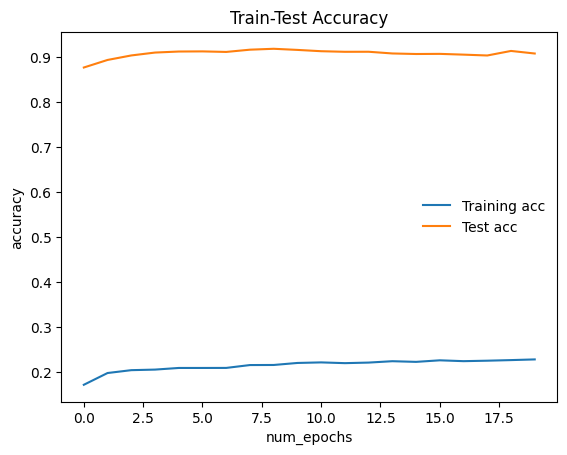

In [22]:
plt.title("Train-Test Accuracy")
plt.plot(train_acces_list, label='Training acc')
plt.plot(test_accs, label='Test acc')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)
plt.show()

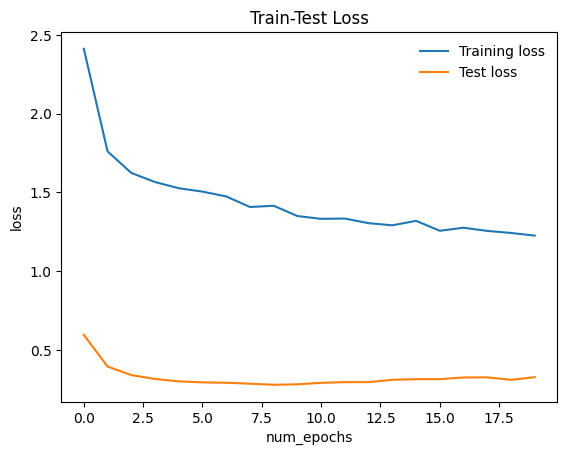

In [23]:
plt.title("Train-Test Loss")
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Test loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.show()